# IMPORTING ALL THE PACKAGES AND MODULES

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#  project name
project_name = 'Emotion_Detectionfinall'

# List OF models
model_names = [
    'VGG16',
    'ResNet50V2',
    'VGG16andResNet50V2',

]

# Base directory ( Google Colab workspace)
base_dir = '/content/drive/MyDrive'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at: {project_dir}')



Project directory structure created at: /content/drive/MyDrive/Emotion_Detectionfinall


# FUNCTION TO COUNT THE IMAGES IN EACH EMOTION DIRECTORY

In [ ]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df



In [ ]:
# Paths to the training and testing directories.
train_dir = '/content/drive/MyDrive/emotions/train'
test_dir = '/content/drive/MyDrive/emotions/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       fearful  disgusted  happy  surprised  angry   sad  neutral
train     4097        436   7223       3171   3995  4830     4965
       sad  surprised  neutral  fearful  happy  disgusted  angry
test  1247        831     1233     1024   1774        111    958


# DATA PREPROCESSING AND DATA SPILT

In [ ]:
import tensorflow as tf

# Define normalization function
def normalize_img(image, label):
    image = tf.cast(image, tf.float32)  # Convert image to float32
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Load datasets
batch_size = 128
image_size = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    crop_to_aspect_ratio=False
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    crop_to_aspect_ratio=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False,
    interpolation="bilinear",
    crop_to_aspect_ratio=False
)





Found 28717 files belonging to 7 classes.
Using 22974 files for training.
Found 28717 files belonging to 7 classes.
Using 5743 files for validation.
Found 7178 files belonging to 7 classes.


In [ ]:
targetnames= train_dataset.class_names
print(targetnames)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


# Calculate class weights to handle imbalances in the training data

In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)


Class Weights Dictionary: {0: 0.9882539682539683, 1: 0.9806268703732871, 2: 0.9893532496424599, 3: 0.9882539682539683, 4: 0.9882539682539683, 5: 0.9926658163265306, 6: 1.0794036061026353}


In [ ]:
# Apply normalization to each dataset
train_dataset = train_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# AutoTune for Compting effeciences

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


# Model and architectures

# **1. VGG16**

In [ ]:


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Model

def Create_VGG16_Model_With_Flatten():
    # Define the input tensor
    inputs = Input(shape=(224, 224, 3))

    # Load the pre-trained VGG16 model without the top layer
    base_model = VGG16(input_tensor=inputs, include_top=False, weights='imagenet')

    # Freeze all layers except the last 5 layers
    base_model.trainable = True
    for layer in base_model.layers[:-5]:
        layer.trainable = False

    # Add a Flatten layer
    x = base_model(inputs, training=True)
    x = Flatten()(x)

    # Add custom layers on top of the base model
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(7, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Instantiate and compile the model
bestmodelvgg = Create_VGG16_Model_With_Flatten()

# Print model summary
bestmodelmodelvgg.summary()

bestmodelvgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,180,871 (80.80 MB)

 Trainable params: 13,544,711 (51.67 MB)

 Non-trainable params: 7,636,160 (29.13 MB)

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/Emotion_Detection27/VGG16'
name = 'mymodelferwithold.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 8,
                          restore_best_weights = True,
                          mode = 'max',
                          verbose = 1
                          )

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=0.0005,
                              mode='min',
                              verbose=1
                              )

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'trainingF2.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop,csv_logger]  # Adjusted as per your use-case



In [ ]:
train_history = bestmodelvgg.fit(
     train_dataset,
    epochs=60,
    validation_data=validation_dataset,
    class_weight=class_weights_dict,
    callbacks = callbacks
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2864 - loss: 2.0665
Epoch 1: val_loss improved from inf to 8.52051, saving model to /content/drive/MyDrive/Emotion_Detection11/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning1.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 1259s 6s/step - accuracy: 0.2865 - loss: 2.0654 - val_accuracy: 0.2520 - val_loss: 8.5205
Epoch 2/50
166/223 ━━━━━━━━━━━━━━━━━━━━ 4:50 5s/step - accuracy: 0.4010 - loss: 1.5687

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 8.52051 to 7.89966, saving model to /content/drive/MyDrive/Emotion_Detection11/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning1.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 919s 4s/step - accuracy: 0.4030 - loss: 1.5637 - val_accuracy: 0.2050 - val_loss: 7.8997
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4513 - loss: 1.4598
Epoch 3: val_loss improved from 7.89966 to 3.28570, saving model to /content/drive/MyDrive/Emotion_Detection11/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning1.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 1255s 6s/step - accuracy: 0.4512 - loss: 1.4598 - val_accuracy: 0.2285 - val_loss: 3.2857
Epoch 4/50
166/223 ━━━━━━━━━━━━━━━━━━━━ 4:51 5s/step - accuracy: 0.4912 - loss: 1.3488
Epoch 4: val_loss improved from 3.28570 to 1.48141, saving model to /content/drive/MyDrive/Emotion_Detection11/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning1.keras
223/223 ━━━━━━━━━━━━━━━━━━━━ 922s 4s/step - accuracy: 0.4927 - loss: 1.344

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

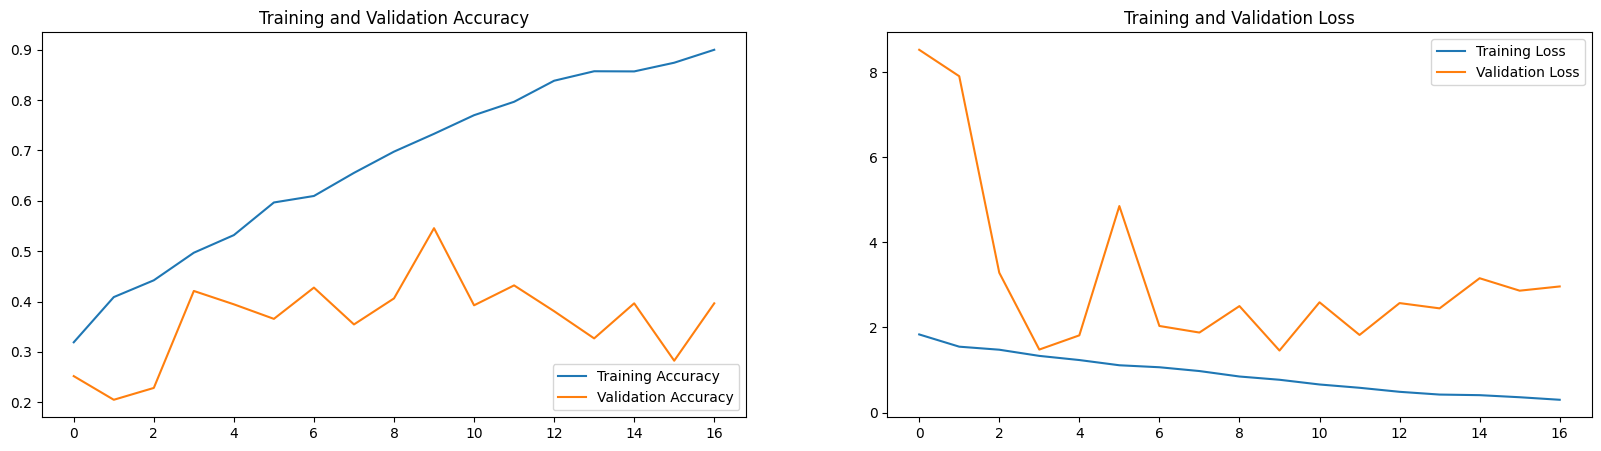

In [ ]:
plot_training_history(train_history)

In [ ]:
# Define the mapping from original classes to the new categories
class_mapping = {
    0: 0,  # Anger -> Negative (0)
    1: 0,  # Disgust -> Negative (0)
    2: 0,  # Fear -> Negative (0)
    3: 1,  # Happy -> Positive (1)
    4: 2,  # Neutral -> Neutral (2)
    5: 0,  # Sad -> Negative (0)
    6: 1   # Surprise -> Positive (1)
}

# Function to map the original labels to the new categories
def map_labels(labels):
    return np.array([class_mapping[label] for label in labels])

In [ ]:

y_pred_probs1 = bestmodelvgg.predict(test_dataset)
y_pred1 = np.argmax(y_pred_probs1, axis=1)  # Get predicted classes
y_pred1=map_labels(y_pred1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 408ms/step


In [ ]:
y_true1 = []
for images, labels in test_dataset:
    labels = np.argmax(labels.numpy(), axis=1)
    mapped_labels = map_labels(labels)
    y_true1.extend(mapped_labels)


In [ ]:
from sklearn.metrics import classification_report

target_names = targetnames
print(classification_report(y_true1, y_pred1, target_names=['Negative','Positive','Neutral']))

              precision    recall  f1-score   support

    Negative       0.64      0.50      0.56      3340
    Positive       0.46      0.77      0.58      2605
     Neutral       0.31      0.05      0.09      1233

    accuracy                           0.52      7178
   macro avg       0.47      0.44      0.41      7178
weighted avg       0.52      0.52      0.49      7178



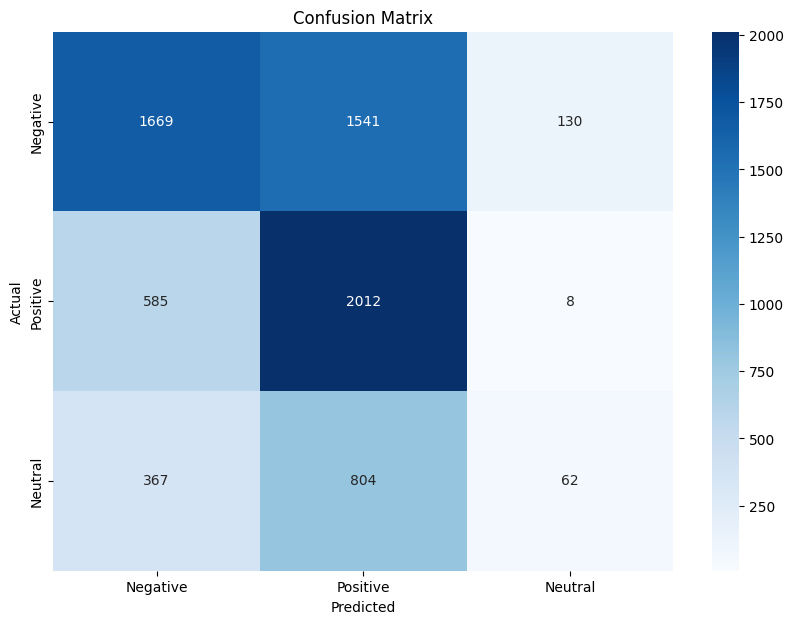

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm =confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Negative','Positive','Neutral'], yticklabels=['Negative','Positive','Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. Resnet50 model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Dense, Flatten
from tensorflow.keras.models import Model

def Create_ResNet50V2_Model_With_Flatten():
    # Define the input tensor
    inputs = Input(shape=(224, 224, 3))

    # Load the pre-trained ResNet50V2 model without the top layer
    base_model = ResNet50V2(input_tensor=inputs, include_top=False, weights='imagenet')

    # Freeze all layers except the last 50 layers
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # Add a Flatten layer
    x = base_model(inputs, training=True)
    x = Flatten()(x)

    # Add custom layers on top of the base model
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x= Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(7, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Instantiate and compile the model
model = Create_ResNet50V2_Model_With_Flatten()

# Print model summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,298,567 (188.06 MB)

 Trainable params: 42,085,127 (160.54 MB)

 Non-trainable params: 7,213,440 (27.52 MB)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/Emotion_Detection27/resnet50'
name = 'resnet50.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 8,
                          restore_best_weights = True,
                          mode = 'max',
                          verbose = 1
                          )

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=0.0005,
                              mode='min',
                              verbose=1
                              )

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'trainingF3.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop,csv_logger]  # Adjusted as per your use-case



In [ ]:
history1 = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset,
    callbacks=callbacks )


Epoch 1/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4937 - loss: 1.6447
Epoch 1: val_loss improved from inf to 1.08292, saving model to /content/drive/MyDrive/Emotion_Detection27/VGG16/mymodelferwithold.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 919s 5s/step - accuracy: 0.4939 - loss: 1.6427 - val_accuracy: 0.5993 - val_loss: 1.0829
Epoch 2/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6719 - loss: 0.8927
Epoch 2: val_loss did not improve from 1.08292
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.6720 - loss: 0.8924 - val_accuracy: 0.6086 - val_loss: 1.1303
Epoch 3/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7944 - loss: 0.5724
Epoch 3: val_loss did not improve from 1.08292
180/180 ━━━━━━━━━━━━━━━━━━━━ 38s 212ms/step - accuracy: 0.7945 - loss: 0.5721 - val_accuracy: 0.6089 - val_loss: 1.3115
Epoch 4/60
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8696 - loss: 0.3755
Epoch 4: val_loss did not improve from 1.08292
180/180 ━━━━━━━

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 15))

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Validation Accuracy')

    # Plot training loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.title('Training Loss')

    # Plot validation loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Validation Loss')

    plt.show()


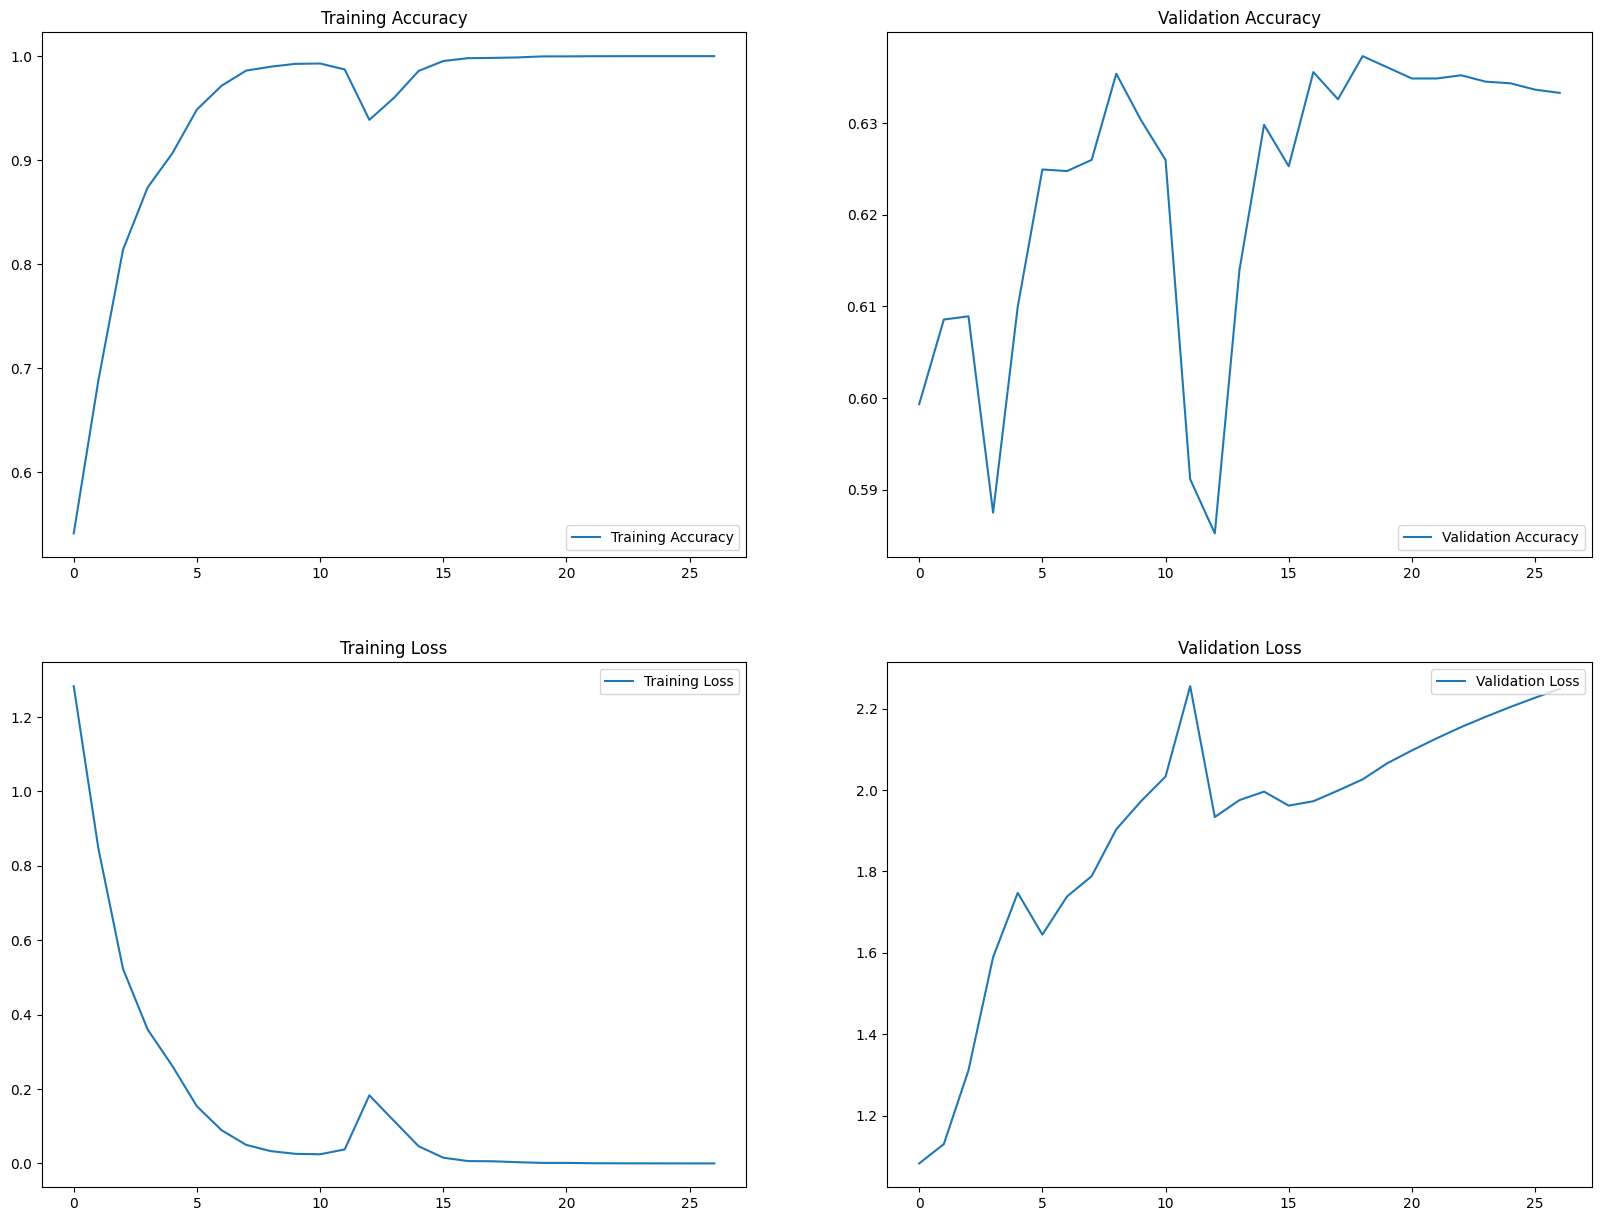

In [ ]:
plot_training_history(history1)

In [ ]:

y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted classes
y_pred=map_labels(y_pred)


In [ ]:
y_true = []
for images, labels in test_dataset:
    labels = np.argmax(labels.numpy(), axis=1)
    mapped_labels = map_labels(labels)
    y_true.extend(mapped_labels)


In [ ]:
from sklearn.metrics import classification_report

target_names = targetnames
print(classification_report(y_true, y_pred, target_names=['Negative','Positive','Neutral']))

              precision    recall  f1-score   support

    Negative       0.81      0.78      0.80      3340
    Positive       0.83      0.87      0.85      2605
     Neutral       0.58      0.59      0.58      1233

    accuracy                           0.78      7178
   macro avg       0.74      0.75      0.74      7178
weighted avg       0.78      0.78      0.78      7178



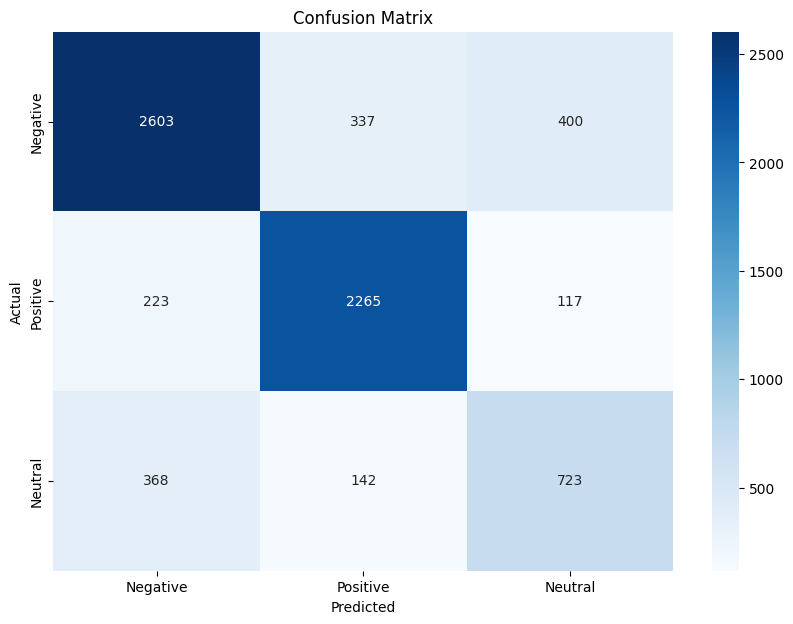

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as pltcc

cm =confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Negative','Positive','Neutral'], yticklabels=['Negative','Positive','Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
loaded_model.save('/content/drive/MyDrive/bestmodelsofar.keras')

# for hybrid model (Resnet50 and VGG16 BOTH)

In [ ]:
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Concatenate
from tensorflow.keras.models import Model

def Create_Combined_Model():
    # Define the input tensor
    inputs = Input(shape=(224, 224, 3))

    # Load the pre-trained ResNet50V2 model without the top layer
    resnet50v2_base = ResNet50V2(input_tensor=inputs, include_top=False, weights='imagenet')

    # Freeze all layers except the last 50 layers in ResNet50V2
    resnet50v2_base.trainable = True
    for layer in resnet50v2_base.layers[:-50]:
        layer.trainable = False

    # Load the pre-trained VGG16 model without the top layer
    vgg16_base = VGG16(input_tensor=inputs, include_top=False, weights='imagenet')

    # Freeze all layers except the last 5 layers in VGG16
    vgg16_base.trainable = True
    for layer in vgg16_base.layers[:-5]:
        layer.trainable = False

    # Get the outputs of both models
    resnet50v2_output = resnet50v2_base(inputs, training=True)
    resnet50v2_output = Flatten()(resnet50v2_output)

    vgg16_output = vgg16_base(inputs, training=True)
    vgg16_output = Flatten()(vgg16_output)

    # Concatenate the outputs of both models
    concatenated = Concatenate()([resnet50v2_output, vgg16_output])

    # Add custom layers on top of the concatenated outputs
    x = Dense(256, activation='relu')(concatenated)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(7, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Instantiate and compile the model
model1 = Create_Combined_Model()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50v2 (Functional)   │ (None, 7, 7, 2048)     │     23,564,800 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 100352)         │              0 │ resnet50v2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 125440)         │              0 │ flatten_1[0][0],       │
│                           │                        │                │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │     32,112,896 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256)            │          1,024 │ dense_4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         32,896 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128)            │            512 │ dense_5[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,256 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 64)             │            256 │ dense_6[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 7)              │            455 │ batch_normalization_5… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 70,435,783 (268.69 MB)

 Trainable params: 55,587,079 (212.05 MB)

 Non-trainable params: 14,848,704 (56.64 MB)

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/Emotion_Detection27/resnet50andvgg16'
name = 'resnet50andvg116.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 8,
                          restore_best_weights = True,
                          mode = 'max',
                          verbose = 1
                          )

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=0.0005,
                              mode='min',
                              verbose=1
                              )

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'trainingF4.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop,csv_logger]  # Adjusted as per your use-case



In [ ]:
history = model1.fit(
    train_dataset,
    epochs=60,
    validation_data=test_dataset,
    callbacks=callbacks )


Epoch 1/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4414 - loss: 1.4424
Epoch 1: val_loss improved from inf to 2.18515, saving model to /content/drive/MyDrive/Emotion_Detection27/ResNet50_Transfer_Learning/ResNet50_Transfer_Learningfinal8.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.4416 - loss: 1.4418 - val_accuracy: 0.3034 - val_loss: 2.1851
Epoch 2/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5659 - loss: 1.1658
Epoch 2: val_loss did not improve from 2.18515
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - accuracy: 0.5662 - loss: 1.1650 - val_accuracy: 0.2920 - val_loss: 2.2265
Epoch 3/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6995 - loss: 0.8261
Epoch 3: val_loss improved from 2.18515 to 2.07349, saving model to /content/drive/MyDrive/Emotion_Detection27/ResNet50_Transfer_Learning/ResNet50_Transfer_Learningfinal8.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.6998 - loss: 0.8253 - val_accuracy: 0.3154 - val_loss: 2.

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 15))

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Validation Accuracy')

    # Plot training loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.title('Training Loss')

    # Plot validation loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Validation Loss')

    plt.show()


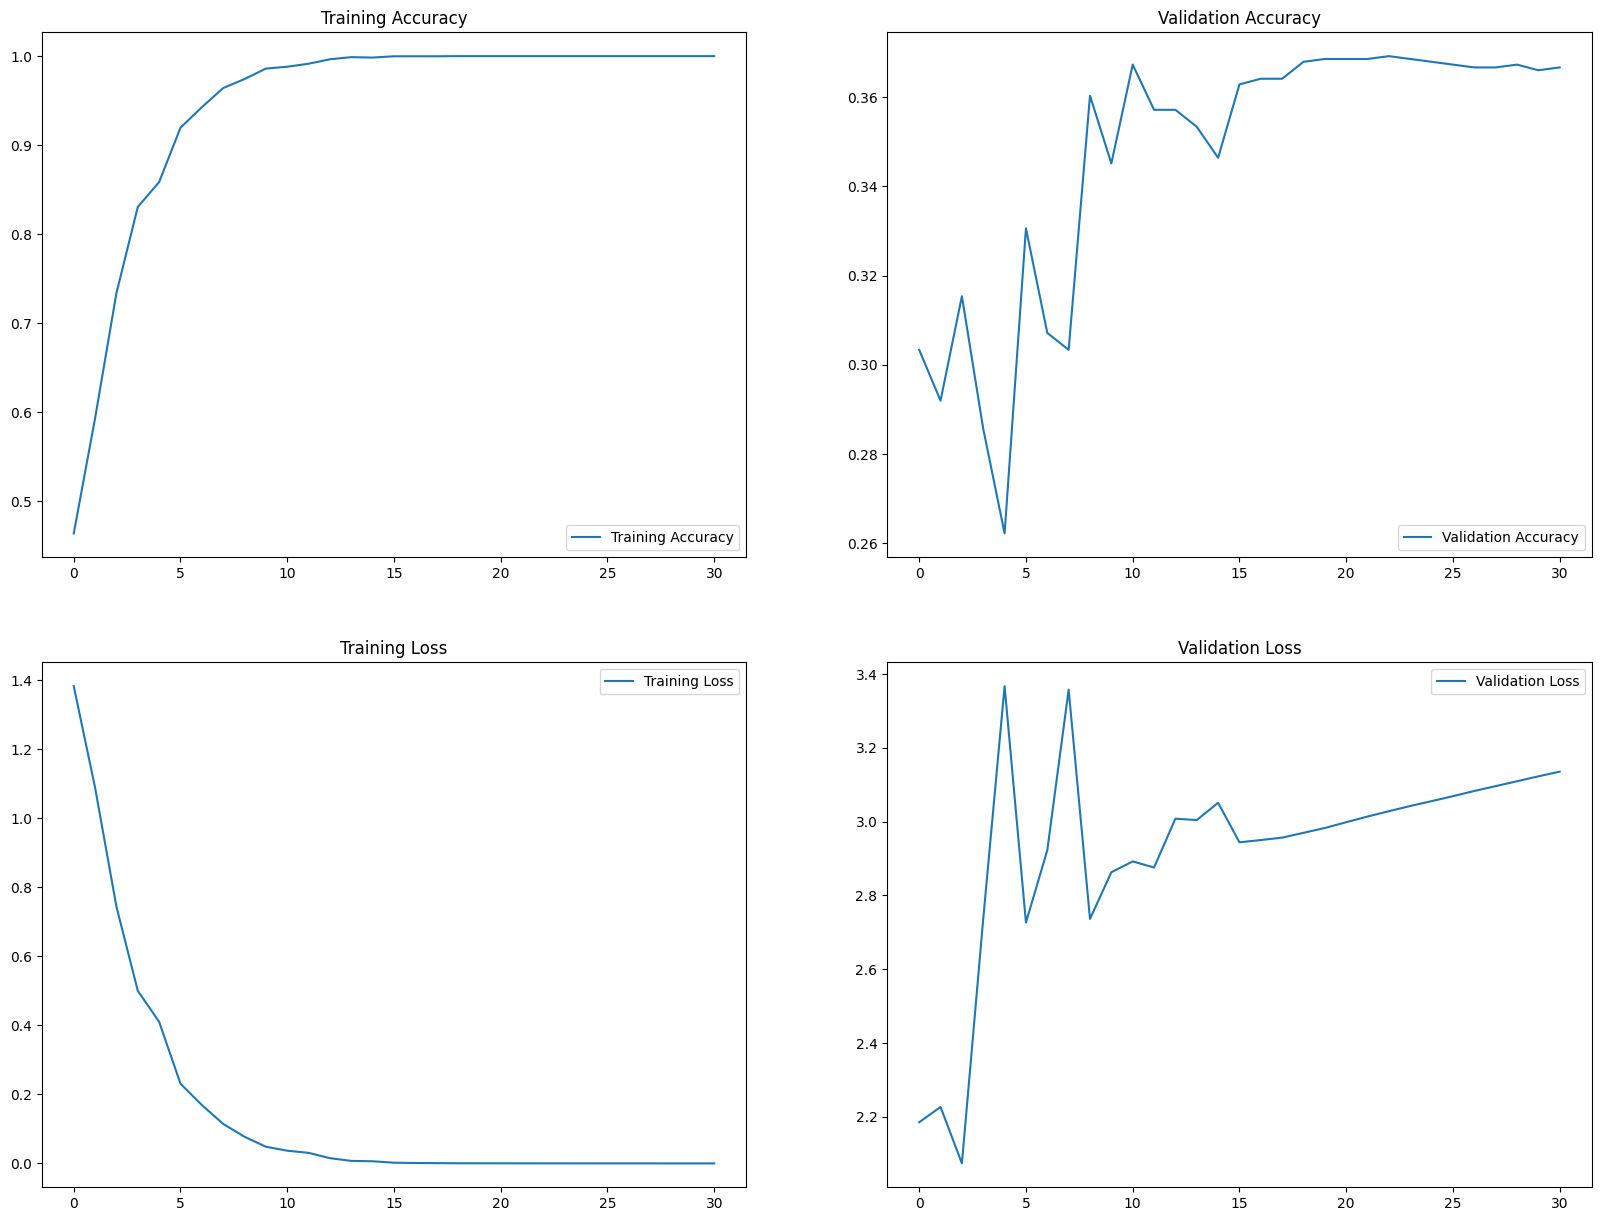

In [ ]:
plot_training_history(history)

In [ ]:

y_pred_probs = bestmodelvgg.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted classes


57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step


In [ ]:
y_true = []
for images, labels in test_dataset:
    labels = np.argmax(labels.numpy(), axis=1)
    mapped_labels = map_labels(labels)
    y_true.extend(mapped_labels)


In [ ]:
from sklearn.metrics import classification_report

target_names = targetnames
print(classification_report(y_true, y_pred, target_names=['Negative','Positive','Neutral']))

              precision    recall  f1-score   support

    Negative       0.67      0.67      0.67      3340
    Positive       0.23      0.19      0.21      2605
     Neutral       0.04      0.05      0.04      1233

    accuracy                           0.39      7178
   macro avg       0.31      0.31      0.31      7178
weighted avg       0.40      0.39      0.40      7178



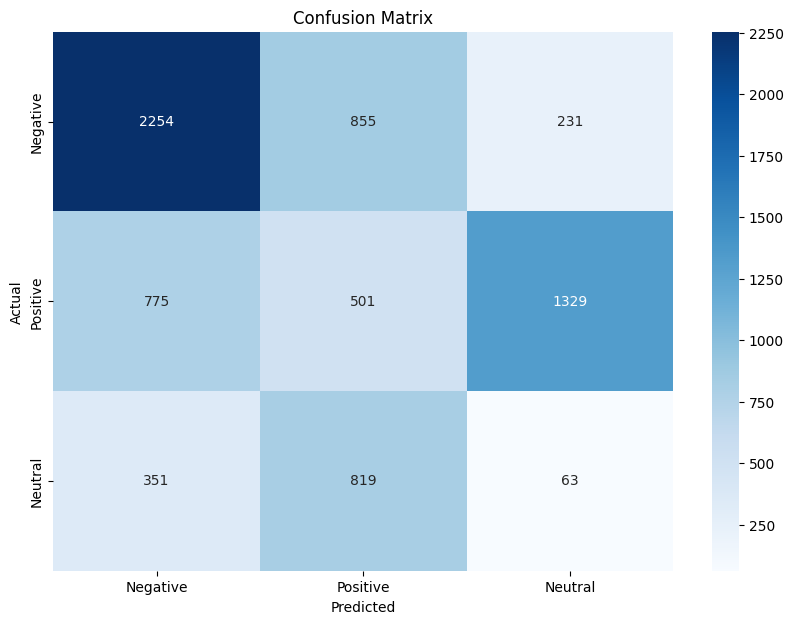

In [ ]:
from sklearn.metrics import cconfusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm =confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Negative','Positive','Neutral'], yticklabels=['Negative','Positive','Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()